In [1]:
import sys
sys.path.insert(0, './utils')

from parameters import *
import annexe
import optimization
import affichage

import matplotlib
import numpy as np
import math
import types
import matplotlib
import cvxpy as cp
import numpy as np

from numpy.random import rand, randn, randint
from numpy import sin, cos, tan, identity, ones, save, load, dot, diag
from scipy.spatial import distance_matrix
from numpy.linalg import svd, norm
from amplpy import AMPL
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc

matplotlib.rcParams['animation.embed_limit'] = 2**128

## Méthode de base

### Génération de données

In [2]:
# Parametres

# Malheureusement, dès qu'on dépasse 6 points pour mode polynomial ou 5 points pour
# mode périodique, notre temps de résoulution avec cette méthode devient conséquant

N = 6       # Nombre de sous-marins
d = 3       # Dimension
P = 3       # Degrée dans la trajectoire
std=1
start = -1   # début
end = 1    # 
Nt= 5       #nombre de points temporel
taux = 1    # Taux de connexion
omega = 1   # Fréquence de la trajectoire périodique
anchor = 4  # Nombre de points d'ancrage pour Procrustes

# Stockage des parametres.
param = parameters(N, d, P, std, omega, start, end, Nt, taux, anchor)

# Définition de mode de la trajectoire.
param.define_mode('polynomial')

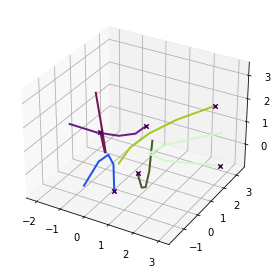

In [3]:
# Génération d'une trajectoire, des points.
A = annexe.generate_A(param)
realX = annexe.generate_trajectory(param, A)
realD = annexe.distance_trajectory(realX   )

# Affichage des trajectoires.
affichage.affichage([realX], param)

### Algorithme

In [4]:
# Définition des horizons
T, K, N = realX.shape

In [5]:
# Calcul de la distance entre les vecteurs.
d = rand(T, N, N)
for t in range(T):
    d[t] = distance_matrix(realX[t].T, realX[t].T)
    
# Calcul de la vitesse d'un sous-marins à tout intervalle du temps.
v = rand(T-1, N)
for t in range(T-1):
    for i in range(N):
        v[t, i] = norm(realX[t, :, i].T - realX[t+1,:,  i].T)

In [6]:
# Sauvegarde des données dans un fichier .dat
file = open("ampl/dgp-python.dat", "w")
file.write("# FILE GENERATED BY python-abdellah \n")

file.write("param n := {0};\n".format(N))
file.write("param k := {0};\n".format(K))
file.write("param time := {0};\n".format(T))

file.write("param d :=")
for t in range(T):
    for i in range(N):
        for j in range(N):
            file.write(" {0} {1} {2} {3}".format(t+1, i+1, j+1,  d[t, i, j]))
file.write(";\n")  

file.write("param vit :=")
for t in range(T-1):
    for i in range(N):
        file.write(" {0} {1} {2}".format(t+1, i+1,  v[t, i]))
file.write(";\n")  

file.close()

In [7]:
# AMPL pour résoudre le problème stocké en dgp.mod

lp = AMPL()
lp.read("ampl/dgp.mod")
lp.readData("ampl/dgp-python.dat")
lp.setOption("solver"  , "baron")
lp.solve()

ndata = lp.getData("n")
N = int(ndata.getRowByIndex(0)[0])
kdata = lp.getData("k")
K = int(kdata.getRowByIndex(0)[0])
tdata = lp.getData("time")
T = int(tdata.getRowByIndex(0)[0])
ddata = lp.getData("d")

solveres = lp.getData("solve_result")
solve_result = solveres.getRowByIndex(0)[0]
objfun = lp.getObjective("f")
objfunval = objfun.value()
xvar = lp.getVariable("x")
x_computed = rand(T, N, K)

for i in range(N):
    for j in range(K):
        for t in range(T):
            x_computed[t, i, j] = xvar[t+1, i+1, j+1].value()
    
print("solution norm is", np.linalg.norm(x_computed))
print("optimal objective function value is", objfunval)
print("solver status is", solve_result)

BARON 21.1.13 (2021.01.13): 0 iterations, optimal within tolerances.
Objective 614.9425014
solution norm is 10.123755078854892
optimal objective function value is 614.9425013798416
solver status is solved


In [8]:
# Matrice de Gram
Gb = rand(T, N, N)
for t in range(T):
    Gb[t] = x_computed[t]@x_computed[t].T
Gb.shape

(5, 6, 6)

5 3 6
(5, 6, 6)
2.0839203586300693e-14
(5, 3, 6)
La méthode de base:  1.944287330519845e-06


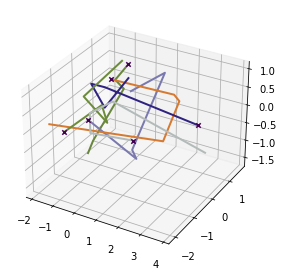

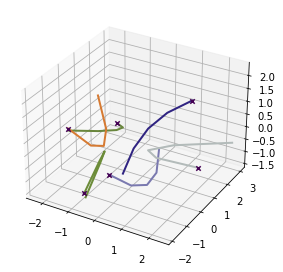

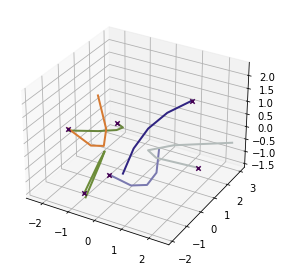

In [9]:
# La reconstruction
print(T, K, N)
print(Gb.shape)
xb, xb_aligned, xb_fin, eb = optimization.reconstruction_basis(Gb, realX.reshape(T, K, N), param)
affichage.affichage([xb, xb_fin, xb_aligned], param)
print("La méthode de base: ", eb)

## Méthode KEDM

### Génération de données

In [12]:
# Parametres

# Ici contrairement à la première méthode, on dépasse 20 points facilement

N = 20       # Nombre de sous-marins
d = 3       # Dimension
P = 3       # Degrée dans la trajectoire
std=1
start = -1   # début
end = 1    # 
Nt= 30       #nombre de points temporel
taux = 1    # Taux de connexion
omega = 1   # Fréquence de la trajectoire périodique
anchor = 4  # Nombre de points d'ancrage pour Procrustes

# Stockage des parametres.
param = parameters(N, d, P, std, omega, start, end, Nt, taux, anchor)

# Définition de mode de la trajectoire.
param.define_mode('bandlimited')

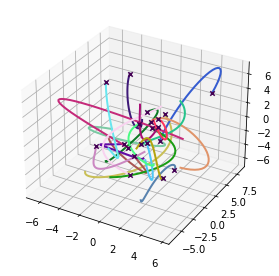

In [13]:
# Génération d'une trajectoire, des points.
A = annexe.generate_A(param)
realX = annexe.generate_trajectory(param, A)
realD = annexe.distance_trajectory(realX   )

# Affichage des trajectoires.
affichage.affichage([realX], param)

### Algorithme

In [14]:
# Résoulution avec KEDM

Gk = optimization.optim_kdm(realD, param)

(30, 20, 20)
                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Mar 15 04:05:50 PM: Your problem has 5200 variables, 43 constraints, and 0 parameters.
(CVXPY) Mar 15 04:05:50 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 04:05:50 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 04:05:50 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.


c:\Users\Mathis\anaconda3\lib\site-packages\cvxpy\problems\problem.py:155: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 04:05:50 PM: Compiling problem (target solver=SCS).
(CVXPY) Mar 15 04:05:50 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) Mar 15 04:05:50 PM: Applying reduction Dcp2Cone
(CVXPY) Mar 15 04:05:51 PM: Applying reduction CvxAttr2Constr
(CVXPY) Mar 15 04:05:52 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Mar 15 04:05:57 PM: Applying reduction SCS
(CVXPY) Mar 15 04:05:57 PM: Finished problem compilation (took 7.245e+00 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Mar 15 04:05:57 PM: Invoki

c:\Users\Mathis\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Mar 15 04:06:41 PM: Problem status: optimal_inaccurate
(CVXPY) Mar 15 04:06:41 PM: Optimal value: 9.195e-09
(CVXPY) Mar 15 04:06:41 PM: Compilation took 7.245e+00 seconds
(CVXPY) Mar 15 04:06:41 PM: Solver (including time spent in interface) took 4.337e+01 seconds


0.004392922825338934
(30, 3, 20)
La méthode KEDM:  1.6302252854987644e-05


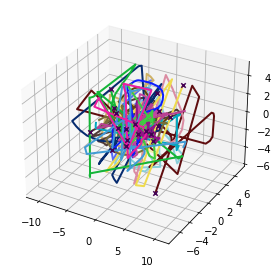

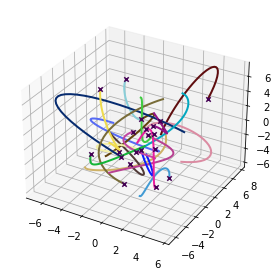

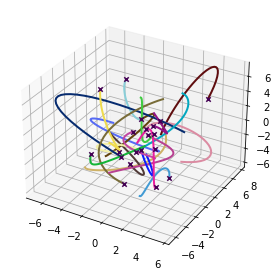

In [19]:
# La reconstruction
Gkbis=np.array([Gk[i].value for i in range(len(Gk))])
xk, xk_aligned, xk_fin, ek = optimization.reconstruction_kedm(Gkbis, realX, param)
affichage.affichage([xk, xk_fin, xk_aligned], param)
print("La méthode KEDM: ", ek)